---
title: "5. Running the model for multiple subjects"
---

# Updating value across subjects

The model we've implemented so far works for a single subject, but we will typically want to run it for multiple subjects.


## Imports

First, we import necessary packages.


In [7]:
import jax
import numpy as np
import jax.numpy as jnp
from functools import partial
from behavioural_modelling.decision_rules import softmax
from behavioural_modelling.utils import choice_from_action_p
from typing import Tuple
import matplotlib.pyplot as plt
import colormaps as cmaps
import os, requests
from matplotlib import font_manager, pyplot as plt

# Some code to make figures look nicer
url = 'https://github.com/google/fonts/blob/main/ofl/heebo/Heebo%5Bwght%5D.ttf?raw=true'
r = requests.get(url)
if r.status_code == 200:
    with open('./Heebo.ttf', 'wb') as f: f.write(r.content)
font_manager.fontManager.addfont('./Heebo.ttf')
plt.rcParams.update({'lines.linewidth': 1, 'lines.solid_capstyle': 'butt', 'legend.fancybox': True, 'axes.facecolor': 'fafafa', 'savefig.edgecolor': 'fafafa', 'savefig.facecolor': 'fafafa', 'figure.subplot.left': 0.08, 'figure.subplot.right': 0.95, 'figure.subplot.bottom': 0.07, 'figure.facecolor': 'fafafa', 'figure.dpi': 80, 'lines.color': '383838', 'patch.edgecolor': '383838', 'text.color': '383838', 'axes.edgecolor': '383838', 'axes.labelcolor': '383838', 'xtick.color': '616161', 'ytick.color': '616161', 'font.family': 'Heebo', 'font.weight': 'regular', 'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10})


## Functions from the previous section

Here we'll copy the functions we've implemented in the previous sections.

In [3]:
@jax.jit
def asymmetric_rescorla_wagner_update(
    value: jax.typing.ArrayLike,
    outcome: jax.typing.ArrayLike,
    chosen: jax.typing.ArrayLike,
    alpha_p: float,
    alpha_n: float,
) -> Tuple[jax.typing.ArrayLike, jax.typing.ArrayLike]:
    """
    Updates the estimated value of a state or action using the Asymmetric Rescorla-Wagner learning rule.

    The function calculates the prediction error as the difference between the actual outcome and the current
    estimated value. It then updates the estimated value based on the prediction error and the learning rate,
    which is determined by whether the prediction error is positive or negative.

    Value estimates are only updated for chosen actions. For unchosen actions, the prediction error is set to 0.

    Args:
        value (float): The current estimated value of a state or action.
        outcome (float): The actual reward received.
        chosen (float): Binary indicator of whether the action was chosen (1) or not (0).
        alpha_p (float): The learning rate used when the prediction error is positive.
        alpha_n (float): The learning rate used when the prediction error is negative.

    Returns:
        Tuple[float, float]: The updated value and the prediction error.
    """

    # Calculate the prediction error
    prediction_error = outcome - value

    # Set prediction error to 0 for unchosen actions
    prediction_error = prediction_error * chosen

    # Set the learning rate based on the sign of the prediction error
    alpha_t = (alpha_p * (prediction_error > 0)) + (alpha_n * (prediction_error < 0))

    # Update the value
    value = value + alpha_t * prediction_error

    return value, prediction_error

def asymmetric_rescorla_wagner_update_choice(
    value: jax.typing.ArrayLike,
    outcome_key: Tuple[jax.typing.ArrayLike, jax.random.PRNGKey],
    alpha_p: float,
    alpha_n: float,
    temperature: float,
    n_actions: int,
) -> np.ndarray:
    """
    Updates the value estimate using the asymmetric Rescorla-Wagner algorithm, and chooses an
    option based on the softmax function.

    Args:
        value (jax.typing.ArrayLike): The current value estimate.
        outcome_key (Tuple[jax.typing.ArrayLike, jax.random.PRNGKey]): A tuple containing the outcome and the PRNG key.
        alpha_p (float): The learning rate for positive outcomes.
        alpha_n (float): The learning rate for negative outcomes.
        temperature (float): The temperature parameter for softmax function.
        n_actions (int): The number of actions to choose from.

    Returns:
        Tuple[np.ndarray, Tuple[jax.typing.ArrayLike, np.ndarray, int, np.ndarray]]:
            - updated_value (jnp.ndarray): The updated value estimate.
            - output_tuple (Tuple[jax.typing.ArrayLike, np.ndarray, int, np.ndarray]):
                - value (jax.typing.ArrayLike): The original value estimate.
                - choice_p (jnp.ndarray): The choice probabilities.
                - choice (int): The chosen action.
                - choice_array (jnp.ndarray): The chosen action in one-hot format.
    """

    # Unpack outcome and key
    outcome, key = outcome_key

    # Get choice probabilities
    choice_p = softmax(value[None, :], temperature).squeeze()

    # Get choice
    choice = choice_from_action_p(key, choice_p)

    # Convert it to one-hot format
    choice_array = jnp.zeros(n_actions, dtype=jnp.int16)
    choice_array = choice_array.at[choice].set(1)

    # Get the outcome and update the value estimate
    updated_value, prediction_error = asymmetric_rescorla_wagner_update(
        value,
        outcome,
        choice_array,
        alpha_p,
        alpha_n,
    )

    return updated_value, (value, choice_p, choice_array, prediction_error)

asymmetric_rescorla_wagner_update_choice = jax.jit(asymmetric_rescorla_wagner_update_choice, static_argnums=(5,))

## Turning our existing code into a function

We had previously written some code to run our update function across multiple trials using `jax.lax.scan`. Here, we will turn this code into a function that can be called for multiple subjects.

In [9]:
def asymmetric_rescorla_wagner_update_choice_iterator(
    outcomes: jax.typing.ArrayLike,
    alpha_p: float,
    alpha_n: float,
    temperature: float,
    n_actions: int,
    key: jax.random.PRNGKey,
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Updates the value estimates using the asymmetric Rescorla-Wagner algorithm and generates choices for each trial.

    Args:
        outcomes (jax.typing.ArrayLike): The outcomes for each trial.
        alpha_p (float): The learning rate for positive outcomes.
        alpha_n (float): The learning rate for negative outcomes.
        temperature (float): The temperature parameter for the softmax function.
        n_actions (int): The number of actions to choose from.
        key (jax.random.PRNGKey): The random key.

    Returns:
        Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
            - values (jnp.ndarray): The value estimates.
            - choice_ps (jnp.ndarray): The choice probabilities.
            - choices (jnp.ndarray): The chosen actions.
            - prediction_errors (jnp.ndarray): The prediction errors.
    """

    # Use partial to create a function with fixed parameters
    asymmetric_rescorla_wagner_update_choice_partial = partial(
        asymmetric_rescorla_wagner_update_choice,
        alpha_p=alpha_p,
        alpha_n=alpha_n,
        temperature=temperature,
        n_actions=n_actions,
    )

    # Generate random keys using JAX
    keys = jax.random.split(key, N_TRIALS)

    # Initialize the value estimates
    value = jnp.ones(5) * 0.5

    # Loop using scan
    _, (values, choice_ps, choices, prediction_errors) = jax.lax.scan(
        asymmetric_rescorla_wagner_update_choice_partial,
        value,
        (outcomes, keys),
    )

    return values, choice_ps, choices, prediction_errors

# JIT
asymmetric_rescorla_wagner_update_choice_iterator = jax.jit(asymmetric_rescorla_wagner_update_choice_iterator, static_argnums=(4,))

We can then use our function as before to simulate data for a single subject.

In [10]:
# Number of trials
N_TRIALS = 100

# Reward probabilities for each of our 5 actions
reward_probs = jnp.array([0.2, 0.4, 0.3, 0.1, 0.5])

# Generate rewards for each trial for each action using Numpy
# There's no need to use JAX for this
rng = np.random.default_rng(0)
rewards = rng.binomial(n=1, p=reward_probs, size=(N_TRIALS, len(reward_probs)))

# Run the model
(values, choice_ps, choices, prediction_errors) = asymmetric_rescorla_wagner_update_choice_iterator(
    outcomes=rewards,
    alpha_p=0.1,
    alpha_n=0.2,
    temperature=1.0,
    n_actions=5,
    key=jax.random.PRNGKey(0),
)

## Extending to multiple subjects

Extending to multiple subjects is straightforward thanks to JAX's vectorization capabilities. We can use the `vmap` function to run our model for multiple subjects in parallel.

When using `vmap`, we supply the function we want to run for each subject, and the axis along which we want to run it. For example, if we have a set of trial outcomes represented by a 2-dimensional array where the first dimension indexes the subject and the second dimension indexes the trial, we can run our model for each subject by setting `axis=0`.

Here, we will create a `vmap`-ed version of our function. We will assume that the trial outcomes are the same for each subject, and that the parameters are different for each subject. 

In [12]:
asymmetric_rescorla_wagner_update_choice_iterator_vmap = jax.vmap(
    asymmetric_rescorla_wagner_update_choice_iterator,
    in_axes=(None, 0, 0, 0, None, None),
)

The key part here is the `in_axes` argument to `vmap`. This tells JAX which arguments to the function are different across subjects. In our case, the only arguments that change across subjects are the parameters, which are vectors with a single dimensions. We therefore set the corresponding value of `in_axes` to `0` for these arguments. The others are set to `None`, which indicates that they are the same for all subjects.

### Running the model for multiple subjects

We can now take our `vmap`-ed function and run it for multiple subjects. We will simulate data for 40 subjects, each with 100 trials.

In [18]:
# Number of subjects
N_SUBJECTS = 40

# Generate parameter values for each subject
alpha_p = np.random.uniform(0.1, 0.5, size=N_SUBJECTS)
alpha_n = np.random.uniform(0.1, 0.5, size=N_SUBJECTS)
temperature = np.random.uniform(0.1, 1.0, size=N_SUBJECTS)

# Run the model for each subject
# NOTE - this doesn't work if you pass keyword arguments
values, choice_ps, choices, prediction_errors = asymmetric_rescorla_wagner_update_choice_iterator_vmap(
    rewards,
    alpha_p,
    alpha_n,
    temperature,
    5,
    jax.random.PRNGKey(0),
)

We can then plot the estimated value for a few subjects to see how they learn over time.

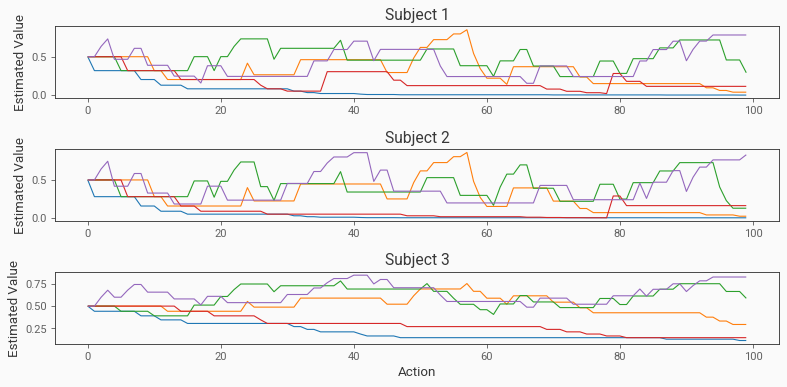

In [26]:
# Plot the estimated values for the first 3 subjects, one subplot per subject
fig, axs = plt.subplots(3, 1, figsize=(10, 5))

for i in range(3):
    axs[i].plot(values[i, :])
    axs[i].set_title(f"Subject {i + 1}")
    if i == 2:
        axs[i].set_xlabel("Action")
    axs[i].set_ylabel("Estimated Value")

plt.tight_layout()



### Extending further

One of the nice things about the `vmap` functionality is that it is easily to extend. If we wanted to, we could add further dimensions to map across. For example, we could map across blocks of trials, or different conditions. This enables us to use our base update functions flexibly without losing performance.

For example, we could first map across blocks, assuming our `outcomes` variable is a 2-dimensional array with the shape (n_blocks, n_trials):

```python
asymmetric_rescorla_wagner_update_choice_iterator_vmap_blocks = jax.vmap(
    asymmetric_rescorla_wagner_update_choice_iterator,
    in_axes=(0, None, None, None, None, None),
)
```

Here, we would set `in_axes=(0, None, None, None, None, None)` because the first argument (the outcomes) changes across blocks, but the others do not (i.e., the parameter values are the same for each block within each subject).

We could then map this function across subjects as before:

```python
asymmetric_rescorla_wagner_update_choice_iterator_vmap_blocks_subjects = jax.vmap(
    asymmetric_rescorla_wagner_update_choice_iterator_vmap_blocks,
    in_axes=(0, None, None, None, None, None),
)
```

## Demonstrating why JAX is helpful

A lot of this imlementation has probably seemed a little convoluted. However, the key advantage of using JAX is that it allows us to write code that is both flexible and efficient. By using `vmap`, we can write our base update functions in a way that is easy to understand and debug, and then use them in a flexible way without losing performance. This is a powerful feature that is unique to JAX.

Speed isn't necessarily a huge issue when we're dealing with small samples of participants, but we're increasingly using datasets with hundreds of participants or more. In these cases, the efficiency of JAX can be a huge advantage, especially if we're running model fitting procedures that require many iterations (e.g., MCMC sampling).

The vectorised operations we've used here (using `vmap`) are much faster than using for loops in Python. These operations can be sped up even further when run on a GPU, which JAX also supports without any need to change the code (if JAX detects a CUDA-compatible GPU, it will automatically run the code on the GPU). This can lead to huge speedups, especially for large datasets.

To demonstrate this, we can compare the speed of our JAX implementation to a naive implementation that uses for loops to iterate over subjects and trials. We'll simulate data for 10000 subjects, each with 100 trials, and compare the speed of the two implementations.

In [66]:
N_SUBJECTS = 10000

def rescorla_wagner_update(value, outcome, chosen, alpha_p, alpha_n):
    # Calculate the prediction error
    prediction_error = outcome - value

    # Set unchosen actions to 0
    prediction_error = prediction_error * chosen

    # Get the alpha for this trial
    alpha_t = (alpha_p * (prediction_error > 0)) + (alpha_n * (prediction_error < 0))

    # Update the value
    value = value + alpha_t * prediction_error

    return value, prediction_error

def softmax(value, temperature):
    # Calculate the unnormalized probabilities
    unnormalized_p = np.exp(value / temperature)

    # Calculate the denominator
    normalizing_constant = np.sum(unnormalized_p)

    # Calculate the probabilities
    p = unnormalized_p / normalizing_constant

    return p

def test_pure_python():

    values = np.ones((N_SUBJECTS, N_TRIALS, 5)) * 0.5

    # RNG
    rng = np.random.default_rng(0)

    # Generate parameter values for each subject
    alpha_p = np.random.uniform(0.1, 0.5, size=N_SUBJECTS)
    alpha_n = np.random.uniform(0.1, 0.5, size=N_SUBJECTS)
    temperature = np.random.uniform(0.1, 1.0, size=N_SUBJECTS)

    for subject in range(len(alpha_p)):
        for trial in range(N_TRIALS - 1):

            # Get the value estimate for the current trial
            value = values[subject, trial]

            # Get choice probabilities
            choice_p = softmax(value, temperature[subject])

            # Choose an action
            choice = rng.choice(np.arange(5), p=choice_p)

            # Convert to one-hot
            choice_array = np.zeros(5)
            choice_array[choice] = 1

            # Update the value estimate using the Rescorla-Wagner learning rule
            value, pe = rescorla_wagner_update(value, rewards[trial], choice_array, alpha_p[subject], alpha_n[subject])

            # Store the updated value estimate
            values[subject, trial] = value

def test_jax():

    # Generate parameter values for each subject
    alpha_p = np.random.uniform(0.1, 0.5, size=N_SUBJECTS)
    alpha_n = np.random.uniform(0.1, 0.5, size=N_SUBJECTS)
    temperature = np.random.uniform(0.1, 1.0, size=N_SUBJECTS)

    # Run the model for each subject
    # NOTE - this doesn't work if you pass keyword arguments
    values, choice_ps, choices, prediction_errors = asymmetric_rescorla_wagner_update_choice_iterator_vmap(
        rewards,
        alpha_p,
        alpha_n,
        temperature,
        5,
        jax.random.PRNGKey(0),
    )


First, we'll test the pure Python/Numpy implementation.

In [67]:
%time test_pure_python()

CPU times: user 25.5 s, sys: 19.3 ms, total: 25.5 s
Wall time: 25.5 s


And next we'll test the JAX implementation.

In [68]:
%time test_jax()

CPU times: user 232 ms, sys: 327 ms, total: 559 ms
Wall time: 281 ms


On my machine, the pure Python/Numpy implementation takes around 25 seconds, while the JAX implementation takes around 0.2 seconds. This is a huge speedup (around 100x), and the difference will be even more pronounced for larger datasets.